In [1]:
import numpy as np
import sys
import os
sys.path.append('../')

# Mayer-f function average for gaussian patch interaction

In [2]:
from scipy import integrate

In [4]:
#calculate the average mayer function for werthim theory
#between off-centered the patch on a particle and the centered
#patch on another particle using a lammps-style gaussian interaction
def Favg(r, rdis, A, B, rcut):  
    
    #place polymer end along the z axis
    polymer_end = np.array([0, 0, r])
    
    #interaction potential
    def SinFpp(theta, phi):
        
        patch = np.array([np.sin(theta)*np.cos(phi),
                          np.sin(theta)*np.sin(phi), 
                          np.cos(theta)])
        patch = patch*rdis
        rpp = np.linalg.norm(polymer_end - patch)
        upp = -A*np.exp(-B*rpp**2)*np.heaviside(rcut - rpp, 0)
        fpp = np.exp(-upp) - 1.0
        
        return np.sin(theta)*fpp
    
    #perform the 2D integration
    integral = integrate.dblquad(SinFpp, 0, 2.0*np.pi, lambda phi: 0, lambda phi: np.pi)
    average = integral[0] / (4.0*np.pi)
    
    return average

### Parameters

In [285]:
dp = 1.0
dc = 5.0

Amin = 0.0
Amax = 20.0
Ainc = 0.1
B = 1.0/0.2**2

rdis = dp*2.0**(1.0/6.0) + (dp + dc)/2.0 - dp
rcut = 0.5*dp
rmin = rdis - rcut*1.1
rmax = rdis + rcut*1.1

dr = 0.005
rs = np.arange(rmin, rmax, dr)
As = np.arange(Amin, Amax, Ainc)

In [385]:
path = './favg__dp={}__dc={}__B={}__rdis={}__rcut={}'.format(dp, dc, B, rdis, rcut)
if not os.path.exists(path):
    os.makedirs(path)

### Generate, save and model the average mayer-f function

In [ ]:
for A in As:
    print "Working on A={}".format(A)
    
    data = [A]
    for r in rs:
        data.append(Favg(r, rdis, A, B, rcut))
    
    #convert to an array and save
    data = np.array(data)
    np.savetxt('{}/A={}.txt'.format(path, A), data)

### Read in the data and create ML model

In [386]:
data = []
for filename in os.listdir(path):
    if filename.endswith(".txt"):
        data.append(np.loadtxt('{}/{}'.format(path, filename)))
    else:
        continue
data = np.array(data)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline 

### Build analytical bond volume NN model for given interactions

In [288]:
from sklearn.preprocessing import StandardScaler

In [289]:
r_scaler = StandardScaler()
A_scaler = StandardScaler()

In [290]:
rs_norm = rs[11:-10]
rs_norm = np.transpose(r_scaler.fit_transform(np.transpose(np.array([rs_norm]))))[0]

In [291]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

In [292]:
#attraction strength
x = data[:,0:1] 
scaler_x.fit(x)
x = scaler_x.transform(x)

#average mayer-f as a function of r
y = data[:,1:]
y = y[:,11:-10]
y = np.log(1.0+y)     

In [293]:
from sklearn.model_selection import train_test_split

In [294]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)

In [295]:
from regression.code.functional_fit_helper import FunctionalFitHelper
from keras.callbacks import ModelCheckpoint

In [296]:
# Save the checkpoint in the /output folder
filepath = "{}/model.hdf5".format(path)

In [297]:
# Keep only a single checkpoint, the best over test accuracy.
checkpoint = ModelCheckpoint(filepath,
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='min')

In [298]:
functional_helper = FunctionalFitHelper()

In [358]:
#functional_helper.InitializeNewModel(x.shape[1], num_cnts=10, hidden_dim=50, activation='relu')
functional_helper.InitializeNewModel(x.shape[1], num_cnts=20, hidden_dim=20, activation='relu')

In [359]:
model = functional_helper.BuildModel(rs_norm)

In [360]:
model.compile(loss='mean_absolute_error', optimizer='adamax')

In [361]:
# Train neural network
history = model.fit(x_train, # Features
                    y_train, # Target vector
                    epochs=60000, # Number of epochs
                    verbose=1, # No output
                    batch_size=100, # Number of observations per batch
                    validation_data=(x_test, y_test))#,
                    #callbacks=[checkpoint]) # Data for evaluation

Train on 900 samples, validate on 100 samples
Epoch 1/60000
900/900 [==============================] - 0s - loss: 1.8276 - val_loss: 1.2515
Epoch 2/60000
900/900 [==============================] - 0s - loss: 0.9892 - val_loss: 0.9124
Epoch 3/60000
900/900 [==============================] - 0s - loss: 0.7709 - val_loss: 0.7850
Epoch 4/60000
900/900 [==============================] - 0s - loss: 0.6782 - val_loss: 0.7251
Epoch 5/60000
900/900 [==============================] - 0s - loss: 0.6326 - val_loss: 0.6938
Epoch 6/60000
900/900 [==============================] - 0s - loss: 0.6069 - val_loss: 0.6757
Epoch 7/60000
900/900 [==============================] - 0s - loss: 0.5916 - val_loss: 0.6636
Epoch 8/60000
900/900 [==============================] - 0s - loss: 0.5808 - val_loss: 0.6542
Epoch 9/60000
900/900 [==============================] - 0s - loss: 0.5725 - val_loss: 0.6455
Epoch 10/60000
900/900 [==============================] - 0s - loss: 0.5648 - val_loss: 0.6363
Epoch 11/6000

900/900 [==============================] - 0s - loss: 0.0222 - val_loss: 0.0253
Epoch 172/60000
900/900 [==============================] - 0s - loss: 0.0221 - val_loss: 0.0254
Epoch 173/60000
900/900 [==============================] - 0s - loss: 0.0220 - val_loss: 0.0255
Epoch 174/60000
900/900 [==============================] - 0s - loss: 0.0219 - val_loss: 0.0251
Epoch 175/60000
900/900 [==============================] - 0s - loss: 0.0218 - val_loss: 0.0251
Epoch 176/60000
900/900 [==============================] - 0s - loss: 0.0217 - val_loss: 0.0251
Epoch 177/60000
900/900 [==============================] - 0s - loss: 0.0217 - val_loss: 0.0251
Epoch 178/60000
900/900 [==============================] - 0s - loss: 0.0216 - val_loss: 0.0250
Epoch 179/60000
900/900 [==============================] - 0s - loss: 0.0215 - val_loss: 0.0250
Epoch 180/60000
900/900 [==============================] - 0s - loss: 0.0214 - val_loss: 0.0249
Epoch 181/60000
900/900 [==============================]

900/900 [==============================] - 0s - loss: 0.0183 - val_loss: 0.0225
Epoch 342/60000
900/900 [==============================] - 0s - loss: 0.0183 - val_loss: 0.0224
Epoch 343/60000
900/900 [==============================] - 0s - loss: 0.0182 - val_loss: 0.0223
Epoch 344/60000
900/900 [==============================] - 0s - loss: 0.0182 - val_loss: 0.0223
Epoch 345/60000
900/900 [==============================] - 0s - loss: 0.0182 - val_loss: 0.0223
Epoch 346/60000
900/900 [==============================] - 0s - loss: 0.0181 - val_loss: 0.0223
Epoch 347/60000
900/900 [==============================] - 0s - loss: 0.0181 - val_loss: 0.0223
Epoch 348/60000
900/900 [==============================] - 0s - loss: 0.0181 - val_loss: 0.0222
Epoch 349/60000
900/900 [==============================] - 0s - loss: 0.0181 - val_loss: 0.0222
Epoch 350/60000
900/900 [==============================] - 0s - loss: 0.0181 - val_loss: 0.0222
Epoch 351/60000
900/900 [==============================]

900/900 [==============================] - 0s - loss: 0.0078 - val_loss: 0.0096
Epoch 512/60000
900/900 [==============================] - 0s - loss: 0.0078 - val_loss: 0.0095ss: 0.007
Epoch 513/60000
900/900 [==============================] - 0s - loss: 0.0078 - val_loss: 0.0096
Epoch 514/60000
900/900 [==============================] - 0s - loss: 0.0077 - val_loss: 0.0094
Epoch 515/60000
900/900 [==============================] - 0s - loss: 0.0076 - val_loss: 0.0095
Epoch 516/60000
900/900 [==============================] - 0s - loss: 0.0075 - val_loss: 0.0093
Epoch 517/60000
900/900 [==============================] - 0s - loss: 0.0075 - val_loss: 0.0092
Epoch 518/60000
900/900 [==============================] - 0s - loss: 0.0074 - val_loss: 0.0092
Epoch 519/60000
900/900 [==============================] - 0s - loss: 0.0074 - val_loss: 0.0092
Epoch 520/60000
900/900 [==============================] - 0s - loss: 0.0073 - val_loss: 0.0091
Epoch 521/60000
900/900 [======================

900/900 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0063
Epoch 682/60000
900/900 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0063
Epoch 683/60000
900/900 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0063
Epoch 684/60000
900/900 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0065
Epoch 685/60000
900/900 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0065
Epoch 686/60000
900/900 [==============================] - 0s - loss: 0.0051 - val_loss: 0.0068
Epoch 687/60000
900/900 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0064
Epoch 688/60000
900/900 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0064
Epoch 689/60000
900/900 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0063
Epoch 690/60000
900/900 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0062
Epoch 691/60000
900/900 [==============================]

KeyboardInterrupt: 

In [ ]:
functional_helper.InitializeOldModel(model=model)

In [51]:
r_new = np.arange(-2,2,0.1)
model_new = functional_helper.BuildModel(rs=r_new)

In [2847]:
len(r_new)

40

In [2821]:
model_new.compile(loss='mean_absolute_error', optimizer='adamax')

-1.42895977835


(1e-06, 0.0037500461563467979)

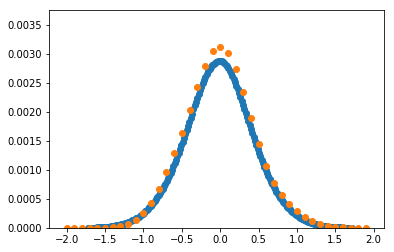

In [2849]:
index = 0

xe = x[index][0]
ye = y[index]
yp = model_new.predict(np.array([[xe]]))[0]
print xe

plt.scatter(rs_norm, ye)
plt.scatter(r_new, yp)

plt.ylim(0.000001,1.2*max(yp))
#plt.ylim(0.00000001,0.0004)
#plt.yscale('log')


1.62986062485


(1e-06, 11.445930862426758)

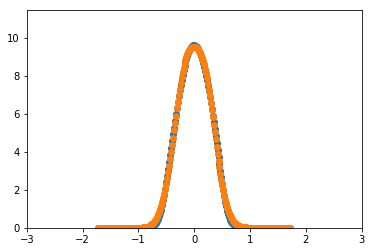

In [305]:
index = 20

xe = x_test[index][0]
ye = y_test[index]
yp = model.predict(np.array([[xe]]))[0]
print xe

#Ae = scaler_x.inverse_transform([[xe]])
#fe = np.exp(xe)*scaler_y.inverse_transform([ye])[0]
#fp = np.exp(xe)*scaler_y.inverse_transform([yp])[0]

plt.scatter(rs_norm, ye)
plt.scatter(rs_norm, yp)

plt.xlim(-3,3)
plt.ylim(0.000001,1.2*max(yp))
#plt.ylim(0.00000001,0.0004)
#plt.yscale('log')


/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


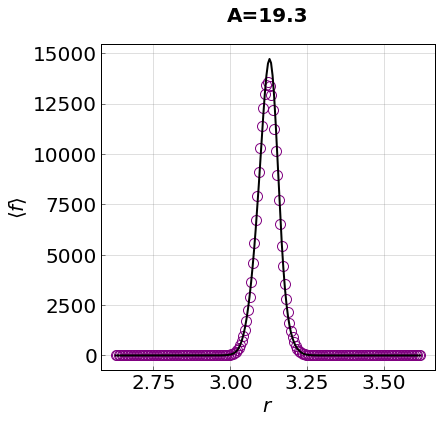

In [384]:
#SELECT TEST DATA
index = -9

xe = x_test[index][0]
ye = y_test[index]
yp = model.predict(np.array([[xe]]))[0]

A = scaler_x.inverse_transform([xe])[0]
r = r_scaler.inverse_transform(rs_norm)

fe = np.exp(ye)-1.0
fp = np.exp(yp)-1.0

plt.plot(r, fe, marker='o', 
         linewidth=0.0, markersize=10, color = 'purple', 
         alpha=2.0, markerfacecolor='None') 

plt.plot(r, fp, marker='o', 
         linewidth=2.0, markersize=0, color = 'black', 
         alpha=2.0, markerfacecolor='None') 

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
#plt.ylim(0.8,0.88)

plt.xlabel(r'$r$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$\langle f \rangle$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('A={}'.format(A), y=1.05, fontdict = title_font)

plt.show()